# Relax Inc. Take-Home Challenge

## Introduction

### Library imports

In [68]:
# General imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from datetime import timedelta

# Sklearn imports
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier

### Helper function(s)

In [69]:
# Printed barrier function
def barrier():
    print("\n <<<","-"*50,">>> \n")

### Data import

In [70]:
users = pd.read_csv("takehome_users.csv", encoding="latin-1", parse_dates=True)
engage = pd.read_csv("takehome_user_engagement.csv", parse_dates=True)

In [71]:
users.head().T

,0,1,2,3,4
object_id,1,2,3,4,5
creation_time,2014-04-22 03:53:30,2013-11-15 03:45:04,2013-03-19 23:14:52,2013-05-21 08:09:28,2013-01-17 10:14:20
name,Clausen August,Poole Matthew,Bottrill Mitchell,Clausen Nicklas,Raw Grace
email,AugustCClausen@yahoo.com,MatthewPoole@gustr.com,MitchellBottrill@gustr.com,NicklasSClausen@yahoo.com,GraceRaw@yahoo.com
creation_source,GUEST_INVITE,ORG_INVITE,ORG_INVITE,GUEST_INVITE,GUEST_INVITE
last_session_creation_time,1398138810.0,1396237504.0,1363734892.0,1369210168.0,1358849660.0
opted_in_to_mailing_list,1,0,0,0,0
enabled_for_marketing_drip,0,0,0,0,0
org_id,11,1,94,1,193
invited_by_user_id,10803.0,316.0,1525.0,5151.0,5240.0


In [72]:
engage.head()

,time_stamp,user_id,visited
0,2014-04-22 03:53:30,1,1
1,2013-11-15 03:45:04,2,1
2,2013-11-29 03:45:04,2,1
3,2013-12-09 03:45:04,2,1
4,2013-12-25 03:45:04,2,1


## Adopted users

In [73]:
# Set the time_stamp to datetime and make it the index
engage.time_stamp = pd.to_datetime(engage.time_stamp)
engage = engage.set_index("time_stamp", drop= True)

In [74]:
# Function to check adoption
def has_adopted(x):
    df_temp = engage.loc[engage["user_id"] == x]
    df_temp = df_temp.resample("D").mean().dropna()
    adopted = 0
    
    for i in range(len(df_temp)-2):
        if df_temp.index[i + 2] - df_temp.index[i] <= timedelta(days=7):
            adopted = 1
            break
        else:
            adopted = 0
    return adopted

In [75]:
# Apply function
users["adopted_user"] = users["object_id"].apply(has_adopted)

In [76]:
print(sum(users["adopted_user"]))
print(sum(users.adopted_user)/len(users.adopted_user))

1656
0.138


**Inference:**
- There are 1656 active users in the dataset
- This constitutes about 14% of the total

## Data Wrangling

In [77]:
# last_session_creation_time to datetime
f = lambda data: datetime.datetime.fromtimestamp(int(data)).strftime("%Y-%m-%d %H:%M:%S")
users["last_session_creation_time"] = users["last_session_creation_time"].map(f, na_action="ignore")

# Creation_time to datetime
users["creation_time"] = pd.to_datetime(users["creation_time"])

- `creation_time` minus `last_session_creation_time` gives us feature `usage_length` that basically indicates how long a user has been active. 

In [78]:
# Convert to datettime
users["last_session_creation_time"] = pd.to_datetime(users["last_session_creation_time"])

# Subtract
users["usage_length"] = users["last_session_creation_time"] - users["creation_time"]

# Change to seconds
users["usage_length"] = [i.total_seconds() for i in users["usage_length"]]

In [79]:
# Email provider as a feature
users["email_provider"] = [i.split("@")[1] for i in users.email]
top = users.email_provider.value_counts().index[:6]

# Set anything not in the top 5 to other
users["email_provider"] = [i if i in top else "other" for i in users.email_provider]

In [80]:
# Impute empty values in users and repeat the above process
users.invited_by_user_id = users.invited_by_user_id.fillna(0)

- Drop unnecessary features: `object_id`, `name`, `last_session_creation_time`, `email`, `creation_time`

In [81]:
feat_df = users.iloc[:, 4:]
feat_df = feat_df.drop("last_session_creation_time", axis=1)
feat_df["usage_length"] = feat_df["usage_length"].fillna(0)

In [82]:
# Generate label features from categorical features
gle = LabelEncoder()
creation_labels = gle.fit_transform(users["creation_source"])
feat_df.creation_source = creation_labels

org_id_labels = gle.fit_transform(users["org_id"])
feat_df.org_id = org_id_labels

invited_labels = gle.fit_transform(users["invited_by_user_id"])
feat_df.org_id = invited_labels

email_labels = gle.fit_transform(users["email_provider"])
feat_df.email_provider = email_labels

In [83]:
feat_df.head()

,creation_source,opted_in_to_mailing_list,enabled_for_marketing_drip,org_id,invited_by_user_id,adopted_user,usage_length,email_provider
0,0,1,0,2325,10803.0,0,-14400.0,6
1,1,0,0,56,316.0,1,11736000.0,2
2,1,0,0,298,1525.0,0,-14400.0,2
3,0,0,0,1104,5151.0,0,72000.0,6
4,0,0,0,1127,5240.0,0,414000.0,6


## Analysis

- `Kneighbors` and `RandomForestClassifier` are both good choices for this data set.
    - This is appropriate as there is a small number of features and rows/records
- However, we have a mix of categorical and numerical data so `RandomForestClassifier` will be easiest to implement.

In [84]:
# Seperate out the labels then split data
data = feat_df.drop("adopted_user", axis=1)
labels = feat_df.adopted_user
X_train, y_train, X_test, y_test = train_test_split(data, labels, test_size=0.2, random_state=123)

In [85]:
# Classifier
rf = RandomForestClassifier(class_weight="balanced_subsample")
rf.fit(X_train, X_test)
rf.score(y_train, y_test)

0.97125

In [86]:
# Classification report and Confusion matrix
y_pred = rf.predict(y_train)
cr = classification_report(y_test, y_pred)
print("Classification Report:", cr, sep="\n", end="\n")

barrier()

cm = confusion_matrix(y_test,y_pred)
print("Confusion matrix:", cm, sep="\n", end="\n")
print(cm)

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.98      0.98      2041
           1       0.91      0.90      0.90       359

    accuracy                           0.97      2400
   macro avg       0.95      0.94      0.94      2400
weighted avg       0.97      0.97      0.97      2400


 <<< -------------------------------------------------- >>> 

Confusion matrix:
[[2009   32]
 [  37  322]]
[[2009   32]
 [  37  322]]


**Note:**
- The results give confidence that the classifier is not overfiting

## Feature Importance

In [87]:
# Ceofficients indexed by feature
feat_import = pd.DataFrame()
feat_import["coef"] = rf.feature_importances_
feat_import = feat_import.set_index(data.columns)
feat_import.coef.nlargest(10)

usage_length                  0.920200
invited_by_user_id            0.023860
org_id                        0.023646
email_provider                0.015341
creation_source               0.010089
opted_in_to_mailing_list      0.003886
enabled_for_marketing_drip    0.002978
Name: coef, dtype: float64

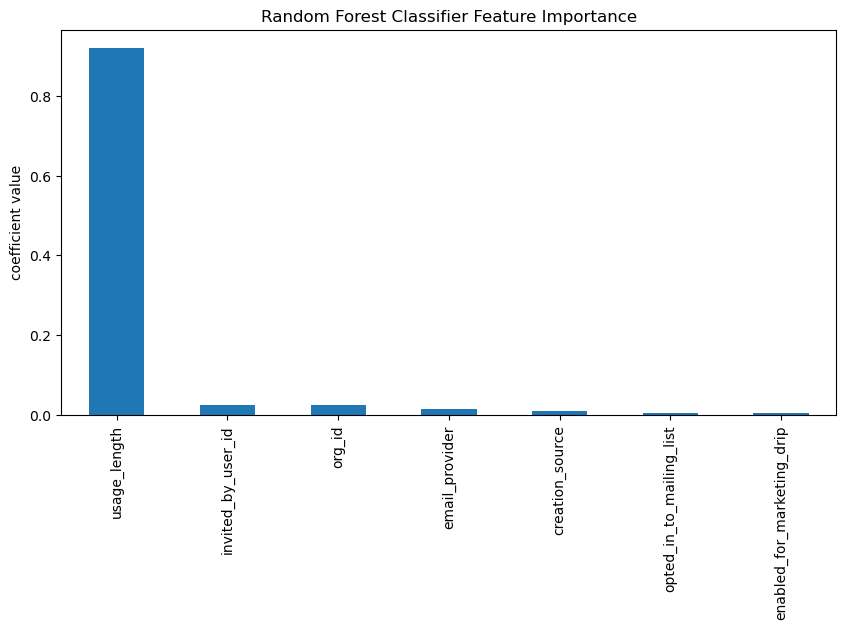

In [88]:
# Plot the results
plt.figure(figsize=(10,5))
(feat_import["coef"]).nlargest(10).plot(kind="bar", x=feat_import.index)
plt.title("Random Forest Classifier Feature Importance")
plt.ylabel("coefficient value")
plt.show()

- `RandomForestClassifer` identified `usage_length` as the best indicator of whether or not a a user becomes an adopted user.
- We should check ECDF.

In [89]:
# ECDF function
def ecdf(data):
    n = len(data)
    x = np.sort(data)
    y = np.arange(1, n+1) / n
    return x, y

In [90]:
adopted = feat_df.usage_length.loc[feat_df["adopted_user"] == 1]
not_adopted = feat_df.usage_length.loc[feat_df["adopted_user"] == 0]

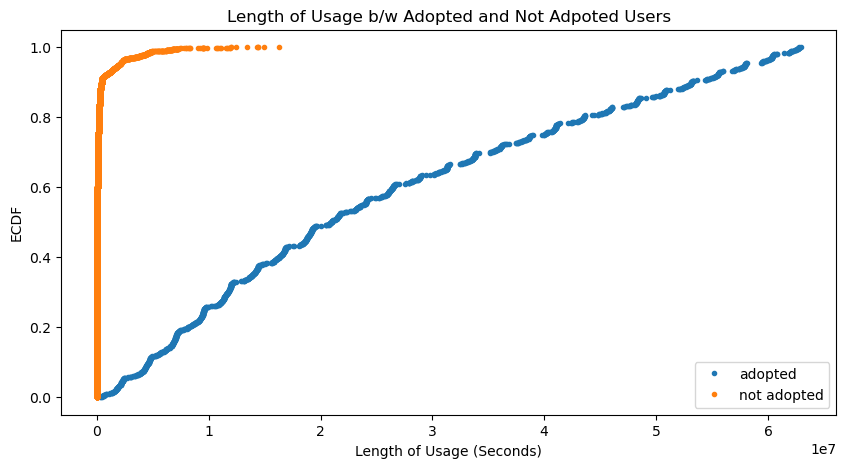

In [91]:
# Plotting
plt.figure(figsize=(10,5))
x_active, y_active = ecdf(adopted)
x_inactive, y_inactive = ecdf(not_adopted)
plt.plot(x_active, y_active, marker=".", linestyle="none")
plt.plot(x_inactive, y_inactive, marker=".", linestyle="none")
plt.title("Length of Usage b/w Adopted and Not Adpoted Users")
plt.xlabel("Length of Usage (Seconds)")
plt.ylabel("ECDF")
plt.legend(["adopted", "not adopted"])
plt.show()

**Inference:**
- The maximum time usage of non-adopted users is roughly 2000 seconds or 230 days.
- Roughly 60% of the active users have usage above that amount of time.